In [1]:
!nvidia-smi

Wed May  8 10:38:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   35C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#How many images in each folder?
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/CDD-CESM_two_datas"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/CDD-CESM_two_datas/Train"
test_dir = "/content/drive/MyDrive/CDD-CESM_two_datas/Test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_cancer = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data_cancer = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 2601 images belonging to 3 classes.
Testing images:
Found 543 images belonging to 3 classes.


In [5]:
#Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
#import depencencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [9]:
#let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=2):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  #Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax',name ="output_layer")
  ])
  return model


In [10]:
resnet_model = create_model(resnet_url, train_data_cancer.num_classes)

In [11]:
#compile our resnet model
resnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
#Let's fit our ResNet model to the data
resnet_history = resnet_model.fit(train_data_cancer,
                                  epochs=50,
                                  steps_per_epoch=len(train_data_cancer),
                                  validation_data=test_data_cancer,
                                  validation_steps=len(test_data_cancer),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240508-104127
Epoch 1/50
82/82 [==============================] - 1176s 14s/step - loss: 0.6131 - accuracy: 0.5152 - val_loss: 0.5721 - val_accuracy: 0.5101
Epoch 2/50
82/82 [==============================] - 87s 1s/step - loss: 0.5318 - accuracy: 0.6067 - val_loss: 0.5263 - val_accuracy: 0.6206
Epoch 3/50
82/82 [==============================] - 84s 1s/step - loss: 0.5081 - accuracy: 0.6151 - val_loss: 0.5218 - val_accuracy: 0.6041
Epoch 4/50
82/82 [==============================] - 86s 1s/step - loss: 0.4859 - accuracy: 0.6424 - val_loss: 0.5420 - val_accuracy: 0.5838
Epoch 5/50
82/82 [==============================] - 87s 1s/step - loss: 0.4685 - accuracy: 0.6524 - val_loss: 0.5444 - val_accuracy: 0.5948
Epoch 6/50
82/82 [==============================] - 87s 1s/step - loss: 0.4612 - accuracy: 0.6659 - val_loss: 0.5429 - val_accuracy: 0.6022
Epoch 7/50
82/82 [==============================] - 83s 1s/step - loss: 0.4469 - a

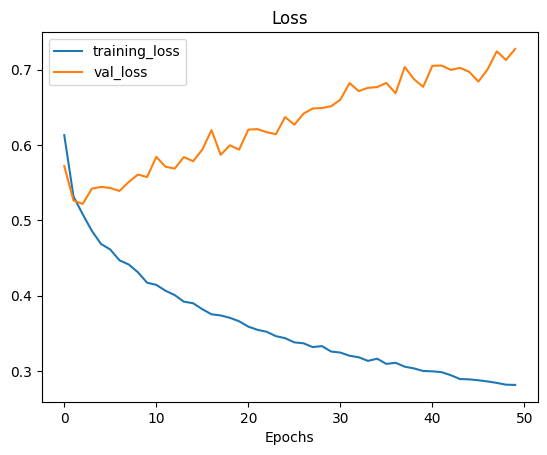

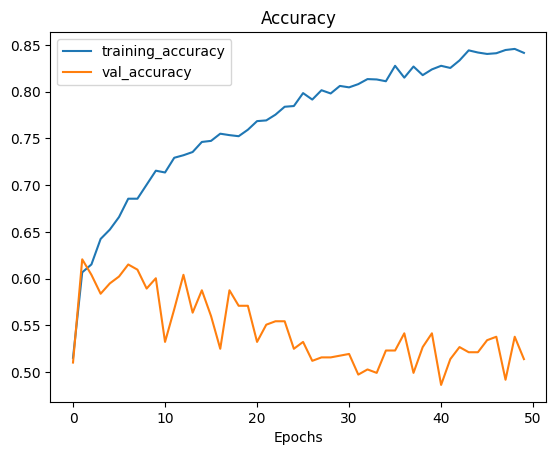

In [13]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow History object.

    Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(resnet_history)

17/17 [==============================] - 17s 981ms/step


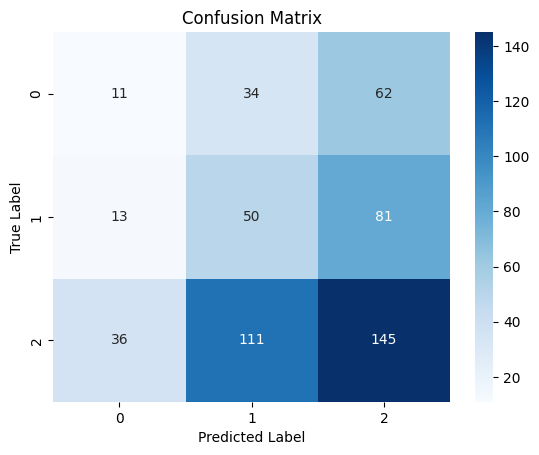

In [17]:
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test data
y_pred = resnet_model.predict(test_data_cancer)

# Convert the predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the test data
y_true = test_data_cancer.classes

# Generate the confusion matrix
confusion_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [18]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred_classes)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.18      0.10      0.13       107
           1       0.26      0.35      0.29       144
           2       0.50      0.50      0.50       292

    accuracy                           0.38       543
   macro avg       0.31      0.32      0.31       543
weighted avg       0.37      0.38      0.37       543

